In [1]:

import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd

import torch.nn as nn

In [2]:
image_dir = "/Users/priyanshdesai07/Plaksha/Deep_Learning/dolphin/vig_pytorch/archive/raw-img/cavallo"

images = []
for filename in os.listdir(image_dir):
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path)

    if image is not None:
        image = cv2.resize(image, (128, 128))
        images.append(image)

print("Number of images read:", len(images))

Number of images read: 2623


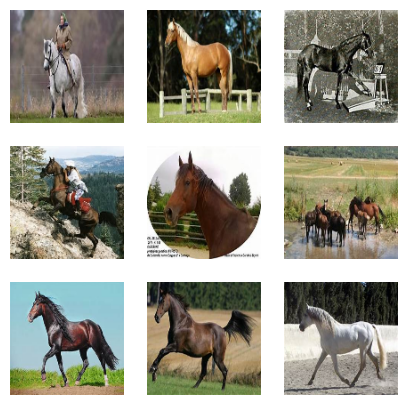

In [3]:
# example of dataset
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

In [4]:
def divide_image(image):
    parts = []
    height, width, _ = image.shape
    part_height = height // 3
    part_width = width // 3
    
    for i in range(3):
        for j in range(3):
            part = image[i*part_height:(i+1)*part_height, j*part_width:(j+1)*part_width]
            parts.append(part)
    
    return parts

In [5]:
def generate_combinations(parts, num_combinations):
    combinations = []
    original_positions = []
    indices = list(range(len(parts)))
    
    for _ in range(num_combinations):
        random.shuffle(indices)
        combination = [parts[i] for i in indices]
        combinations.append(combination)
        original_positions.append(indices.copy())
    
    return combinations, original_positions

In [6]:
def stitch_shuffled_image(parts):
    num_parts = len(parts)
    part_size = parts[0].shape[0]  # Assuming all parts are square
    
    stitched_image_size = int(np.sqrt(num_parts) * part_size)
    stitched_image = np.zeros((stitched_image_size, stitched_image_size, parts[0].shape[2]), dtype=np.uint8)
    
    for i in range(stitched_image.shape[0] // part_size):
        for j in range(stitched_image.shape[1] // part_size):
            part_index = i * int(stitched_image.shape[0] / part_size) + j
            stitched_image[i*part_size:(i+1)*part_size, j*part_size:(j+1)*part_size] = parts[part_index]
    
    return stitched_image

In [7]:
input_data = []
target_data = []
non_converted_target_data = []

for image in images:
    parts = divide_image(image)
    combinations, original_positions = generate_combinations(parts, 10)
    
    for idx, combination in enumerate(combinations):
        shuffled_image = stitch_shuffled_image(combination)
        input_data.append(shuffled_image)

        dummy_target = np.zeros((9, 9), dtype=np.uint8)
        for i in range(9):
            dummy_target[i, original_positions[idx][i]] = 1

        target_data.append(dummy_target.flatten())
        non_converted_target_data.append(original_positions[idx])

In [8]:
input_data = np.array(input_data)
target_data = np.array(target_data)

print("Input data shape:", input_data.shape)
print("Target data shape:", target_data.shape)

Input data shape: (26230, 126, 126, 3)
Target data shape: (26230, 81)


target
[[0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]]
non_converted_target [5, 2, 1, 3, 8, 7, 0, 4, 6]


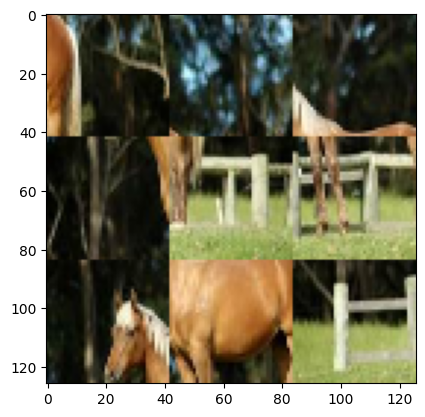

In [9]:
idx = random.randint(0, len(input_data))
print("target", target_data[idx].reshape(9, 9), sep="\n")
print("non_converted_target", non_converted_target_data[idx])
plt.imshow(cv2.cvtColor(input_data[idx], cv2.COLOR_BGR2RGB))

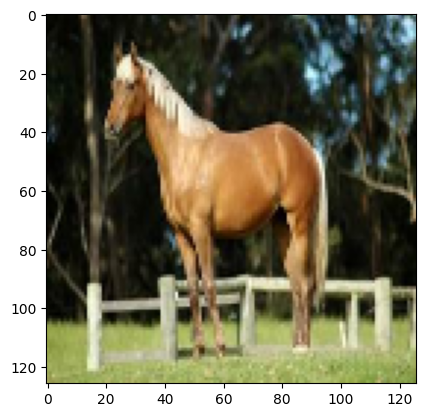

In [10]:
# checking if the target sequence is correct
def reconstructed_image(img, non_converted_target_data):
    
    parts = divide_image(img)
    sequenced = [0] * 9
    for i, part in enumerate(parts):
        sequenced[non_converted_target_data[i]] = part

    stiched_img = stitch_shuffled_image(sequenced)
    return stiched_img

reconstructed_img = reconstructed_image(input_data[idx], non_converted_target_data[idx])
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))

In [11]:
import torch.optim as optim


num_epochs = 10
batch_size = 64

In [12]:
class JigsawDataset(Dataset):
    def __init__(self, input_data, target_data, transform=None):
        self.input_data = input_data
        self.target_data = target_data
        self.transform = transform
        
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        image = self.input_data[idx]
        target = self.target_data[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [13]:
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

train_dataset = JigsawDataset(X_train, y_train)
test_dataset = JigsawDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [14]:
from clip_model import ModifiedResNet
model = ModifiedResNet(layers=[3, 4, 6, 3], output_dim=1000, heads=8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:


model.train()  # Set the model to training mode

feature_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        inputs = inputs.permute(0, 3, 1, 2).float()
        
        feature_list.append(inputs)
        

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs,features = model(inputs,feature_list)  # Adjust this if your model returns more than one output



        break
        # Compute the loss
        loss = criterion(outputs, labels.float())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    break
print('Finished Training')

2048 tensor([[[[1.4121e+00, 0.0000e+00, 9.7938e-01],
          [1.4957e+00, 3.4877e+00, 0.0000e+00],
          [7.0671e-01, 1.6878e+00, 6.1740e-01]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.7412e+00, 4.1262e-01, 2.3896e-01],
          [1.0854e+00, 2.5071e+00, 0.0000e+00]],

         [[1.1371e+00, 1.2382e+00, 1.2286e+00],
          [4.1570e-01, 6.1780e-01, 4.1727e-02],
          [2.6083e-01, 4.1053e-01, 1.3181e+00]],

         ...,

         [[2.4506e-01, 0.0000e+00, 1.1427e-01],
          [8.3699e-01, 0.0000e+00, 9.4608e-01],
          [2.9822e-01, 5.4288e-02, 7.4038e-01]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00],
          [9.5873e-01, 0.0000e+00, 0.0000e+00],
          [1.4346e-03, 5.2789e-01, 8.3844e-01]],

         [[1.3515e+00, 5.1188e-01, 0.0000e+00],
          [3.0271e-01, 7.1553e-01, 0.0000e+00],
          [5.9725e-01, 8.6835e-01, 3.9590e-01]]],


        [[[0.0000e+00, 3.1092e+00, 3.4228e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00],
      

RuntimeError: The size of tensor a (10) must match the size of tensor b (17) at non-singleton dimension 0

In [38]:
feature_list[0][0].shape

torch.Size([3, 120, 120])

In [48]:
labels.shape

torch.Size([64, 81])

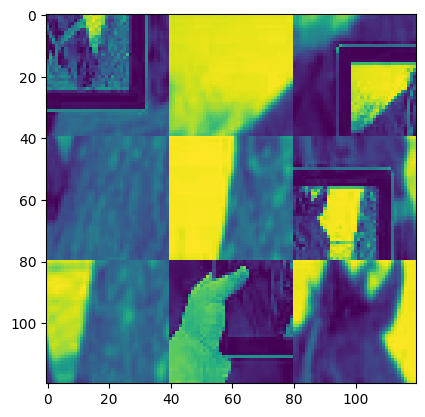

In [39]:
plt.imshow(feature_list[0][0][0].detach().numpy())

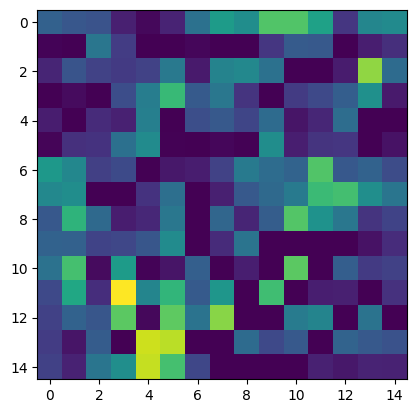

In [40]:
plt.imshow(feature_list[1][0][0].detach().numpy())

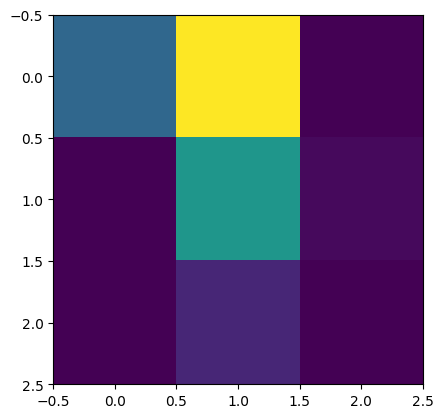

In [41]:
plt.imshow(feature_list[2][0][0].detach().numpy())

In [42]:
mean_x = feature_list[0].mean(dim=1, keepdim=True)

mean_x

tensor([[[[106.6667, 135.3333, 108.3333,  ...,  40.3333,  47.0000,  56.3333],
          [107.3333, 124.3333, 103.3333,  ...,  38.0000,  45.6667,  55.3333],
          [ 90.3333, 111.6667,  89.6667,  ...,  36.3333,  45.6667,  54.0000],
          ...,
          [ 70.3333,  82.3333, 136.6667,  ..., 243.6667, 246.6667, 247.6667],
          [ 69.0000,  71.3333, 123.0000,  ..., 241.0000, 246.3333, 249.0000],
          [ 73.3333,  65.3333, 103.0000,  ..., 231.6667, 244.0000, 247.0000]]],


        [[[ 86.6667, 127.3333,  96.0000,  ..., 251.0000, 251.0000, 251.0000],
          [ 69.6667, 111.6667, 112.6667,  ..., 251.0000, 251.0000, 251.0000],
          [ 67.6667,  92.6667, 105.6667,  ..., 246.3333, 250.0000, 251.0000],
          ...,
          [251.0000, 248.0000, 249.0000,  ...,  62.0000,  69.6667,  74.6667],
          [251.0000, 248.0000, 249.0000,  ...,  62.0000,  67.0000,  74.3333],
          [251.0000, 248.0000, 249.0000,  ...,  64.3333,  62.0000,  80.0000]]],


        [[[146.6667, 138.6

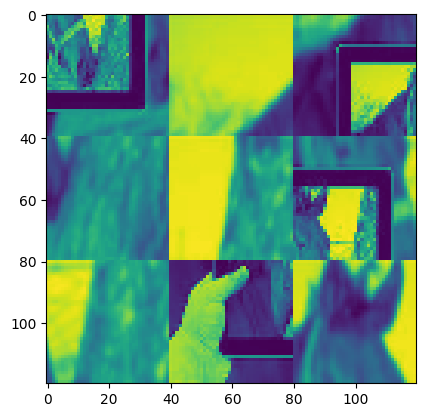

In [43]:
plt.imshow(mean_x[0][0].detach().numpy())

In [44]:
mean_x = feature_list[1].mean(dim=1, keepdim=True)

mean_x

tensor([[[[0.8061, 0.9439, 0.8800,  ..., 1.1347, 1.2886, 1.0549],
          [0.9083, 0.9037, 1.0163,  ..., 1.8637, 1.9459, 1.7167],
          [0.8007, 0.9136, 0.9911,  ..., 1.7558, 2.0337, 1.8381],
          ...,
          [0.9313, 1.1534, 1.5337,  ..., 0.9218, 0.9523, 0.8516],
          [0.8739, 1.0236, 1.1889,  ..., 0.9104, 0.8752, 0.8366],
          [0.8586, 0.8679, 1.0565,  ..., 0.8315, 0.8187, 0.7691]]],


        [[[0.8413, 0.8045, 0.9402,  ..., 1.7899, 1.5730, 1.2273],
          [0.7912, 0.8852, 0.9869,  ..., 1.5508, 1.3363, 1.2012],
          [0.8581, 1.0161, 0.9260,  ..., 1.2273, 0.9959, 0.8051],
          ...,
          [1.1804, 1.5057, 1.5991,  ..., 0.9726, 1.0252, 0.9360],
          [1.2107, 1.5060, 1.4539,  ..., 0.9537, 1.0219, 0.9654],
          [0.9684, 1.1067, 1.1205,  ..., 0.8846, 0.9127, 0.8279]]],


        [[[0.7911, 0.8856, 0.9500,  ..., 0.8670, 0.8405, 0.8084],
          [1.0439, 1.1010, 0.9195,  ..., 0.9643, 0.9740, 0.7587],
          [0.9830, 1.0494, 0.9221,  ..

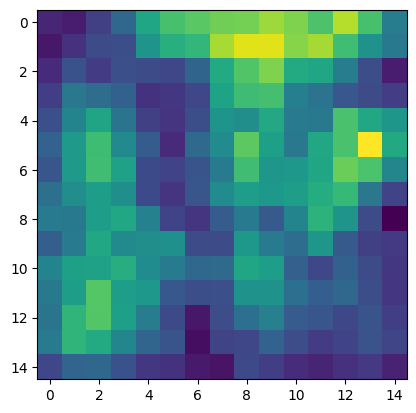

In [45]:
plt.imshow(mean_x[1][0].detach().numpy())

In [46]:
mean_x = feature_list[2].mean(dim=1, keepdim=True)

mean_x

tensor([[[[0.5882, 0.7031, 0.6584],
          [0.6497, 0.8399, 0.7123],
          [0.6012, 0.7009, 0.6087]]],


        [[[0.5811, 0.7523, 0.7842],
          [0.6200, 0.8488, 0.7951],
          [0.6015, 0.7129, 0.6076]]],


        [[[0.5065, 0.5324, 0.5036],
          [0.5026, 0.5449, 0.5187],
          [0.4734, 0.5269, 0.4870]]],


        [[[0.5169, 0.5775, 0.5972],
          [0.5488, 0.6741, 0.6442],
          [0.5305, 0.6240, 0.6348]]],


        [[[0.5028, 0.5389, 0.4909],
          [0.5380, 0.5994, 0.5131],
          [0.5431, 0.5393, 0.5000]]],


        [[[0.5220, 0.5668, 0.5220],
          [0.5568, 0.6176, 0.6060],
          [0.5051, 0.5844, 0.5587]]],


        [[[0.5047, 0.4954, 0.4973],
          [0.5066, 0.5492, 0.5081],
          [0.4512, 0.5140, 0.4817]]],


        [[[0.6795, 0.7081, 0.6551],
          [0.7918, 0.9385, 0.7411],
          [0.6561, 0.7342, 0.6601]]],


        [[[0.5023, 0.5384, 0.4701],
          [0.5260, 0.5389, 0.5444],
          [0.4641, 0.5247, 0.490

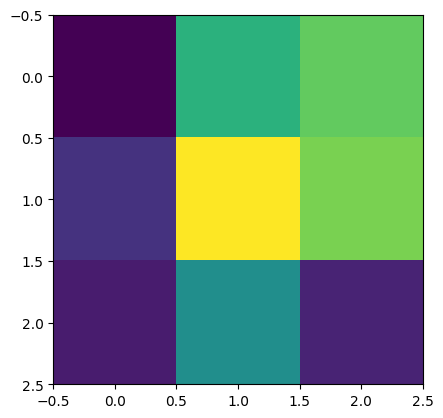

In [47]:
plt.imshow(mean_x[1][0].detach().numpy())